# Everyone 헤드포즈 기준 시각화

In [1]:
import os
import sys
import pandas as pd

In [2]:
def grep_recur(base_path, pattern="*.*"):
    from itertools import chain
    sub_greps = list(chain(*[grep_recur(dp, pattern) for dp in grep_dirs(base_path)]))
    return grep_files(base_path, pattern) + sub_greps

def grep_files(base_path, pattern="*.*"):
    import glob
    return glob.glob("{}/{}".format(base_path, pattern))

def grep_dirs(base_path):
    import os
    file_paths = [os.path.join(base_path, name) for name in os.listdir(base_path)]
    return [p for p in file_paths if os.path.isdir(p)]

def decode_jpg(data):
    img = np.frombuffer(data, dtype='uint8')
    img = cv2.imdecode(img, cv2.IMREAD_COLOR)
    return img

## Everyone 

In [3]:
mm3d_path = "/home/elvin/host/mnt/ssd3/dfa/"
everyone_base_path = "/home/elvin/host/mnt/ssd3/everyone-npz/"

In [4]:
npz_paths = grep_recur(everyone_base_path)
mmp_paths = grep_recur(mm3d_path)

# 원본 프로파일 개수
print('num profiles:', len(npz_paths))
print('num mm params:', len(mmp_paths))

# 3dmm 파라미터가 존재하는 프로파일 아이디들
mm_pids = [p[-9:-4] for p in mmp_paths]
npz_paths = [p for p in npz_paths if p[-9:-4] in mm_pids]  

# 3dmm 파라미터가 존재하는 프로파일 npz
print('num profiles have mm', len(npz_paths))

num profiles: 1474
num mm params: 1324
num profiles have mm 1324


## rotation table 생성 PID/FID to (yaw, pitch, roll) 

In [5]:
def make_rotation_table(mmp_paths):
    rd = np.rad2deg
    
    table = {}
    for m_path in mmp_paths[:]:
        pid = m_path[-9:-4]
        npz = np.load(m_path, allow_pickle=True)
        items = npz['items']
        
        fid_to_r = {}
        table[pid] = fid_to_r
        for item in items:
            fid = item['frame_id']
            ypr = {'yaw':rd(item['yaw']), 'pitch':rd(item['pitch']), 'roll': rd(item['roll'])}
            fid_to_r[fid] = ypr
            
    return table

In [6]:
def write_rotation_table(data, out_path):
    import json
    with open(out_path, 'w') as f:
        json.dump(str(data), f)

In [7]:
def load_rotation_table(path):
    import json
    with open(path, 'r') as f:
        data = json.load(f)
    return eval(data)

In [8]:
def sample_dict(d, sample_ratio=10):
    keys = np.array(list(d.keys()))
    num_items = len(keys)
    sample_idx = np.random.choice(num_items, int(num_items/sample_ratio))
    keys_sampled = keys[sample_idx]
    return {k:v for k,v in d.items() if k in keys_sampled}

## heatmap dataframe

In [9]:
def count_component(rotation_table, selector):
    ar = lambda x : int(np.around(x))
    x, y = selector
    counters = {}
    for pid, items in rotation_table.items():
        for fid, ypr in items.items():
            vx, vy = ar(ypr[x]), ar(ypr[y])
            key = (vx, vy)
            if key not in counters:
                counters[key] = 0
            counters[key] += 1
    return counters

In [10]:
def make_count_heatmap(counters, selector, x_rng, y_rng):
    heatmap = []
    x, y = selector
    for i in range(x_rng[0], x_rng[1]+1):
        for j in range(y_rng[0], y_rng[1]+1):
            key = (i, j)
            count = counters[key] if key in counters else 0
            heatmap.append({x:i, y:j, 'count':count})
    return heatmap

In [316]:
def vis_rotation_heatmap(r_table, selector, x_rng, y_rng, 
                         pids=None, figsize=(16,16), annot=False):
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    table = {k:v for k,v in r_table.items() if k in pids}
    
    counters = count_component(table, selector)
    heatmap = make_count_heatmap(counters, selector, x_rng, y_rng)
    df_heatmap = pd.DataFrame(heatmap).pivot(selector[0], selector[1], 'count')

    f, ax = plt.subplots(figsize=figsize)
    g = sns.heatmap(df_heatmap, cbar=False, annot=annot, fmt="d", vmin=0)
    g = g.set_xticklabels(labels=g.get_xticklabels(), rotation=45)
    plt.title('{} '.format('headpose count'))

# headpose distribution

In [94]:
# rotation_table = make_rotation_table(mmp_paths)
# write_rotation_table(rotation_table, '/home/elvin/host/mnt/ssd3/nps/rotation_table.json')
r_table = load_rotation_table('/home/elvin/host/mnt/ssd3/nps/rotation_table.json')

## 헤드포즈 기준 오차 히트맵 (프로파일)

In [205]:
def make_error_heatmap(fid_to_err, rotation_table, selector, x_rng, y_rng, empty=0):
    x, y = selector
    ar = lambda x : int(np.around(x))
    
    errors = {}
    for fid, err in fid_to_err.items():
        fid = '{:05d}'.format(fid)
        if fid not in rotation_table:
            continue
        ypr = rotation_table[fid]
        key = (ar(ypr[x]), ar(ypr[y]))
        if key not in errors:
            errors[key] = []
        errors[key].append(err)
    
    heatmap = []
    for i in range(x_rng[0], x_rng[1]+1):
        for j in range(y_rng[0], y_rng[1]+1):
            key = (i, j)
            mse = empty
            if key in errors:
                errs = errors[key]
                if len(errs) > 1:   # EXP: 2개 이상만 TODO:capsule
                    mse = ar(np.mean(errs))
            heatmap.append({x:i, y:j, 'mse':mse})
            
    return heatmap 

In [356]:
def vis_error_heatmap(pid, fid_to_err, rot_table, selector, x_rng, y_rng, 
                      annot=False, title=None, figsize=(16,16)):
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    target_table = rot_table[pid]
    heatmap = make_error_heatmap(fid_to_err, target_table, selector, x_rng, y_rng)
    df_heatmap = pd.DataFrame(heatmap).pivot(selector[0], selector[1], 'mse')
    
    f, ax = plt.subplots(figsize=figsize)
    # cmap = sns.cubehelix_palette(200, start=2, rot=0, dark=0, light=.95, reverse=True)
    g = sns.heatmap(df_heatmap, cbar=False, annot=annot, fmt="d")
                    # center=70.0, vmin=0.0, vmax=100.0, cmap=cmap)
    g = g.set_xticklabels(labels=g.get_xticklabels(), rotation=45)
    
    title = '[{}] err'.format(pid) if title is None else title
    plt.title(title, fontsize=16)

### Load report

In [176]:
def load_error_report(pid):
    import json
    base_path = '/home/elvin/host/mnt/ssd3/report/everyone-3dmm/'
    with open(os.path.join(base_path, '{}.json'.format(pid))) as f:
        report = json.load(f)
    return eval(report)

In [193]:
sys.path.append(os.path.abspath('../'))
from stats.evaluation import Evaluation
from stats.profile_report import ProfileReport

In [357]:
def show_error_report(pid, r_table, selector, x_rng, y_rng, annot=True):
    # 데이터 로드
    error_report = load_error_report(pid)
    valid_err, train_err = er['valid'], er['train']
    
    # 아이템 개수
    num_vl, num_tr = len(valid_err), len(train_err)
    num_total = num_vl + num_tr
    
    # stat 수치
    avg_vl =  np.mean(list(er['valid'].values()))
    avg_tr =  np.mean(list(er['train'].values()))
    
    # 타이틀
    vt = '[{}] VALID:{:.2f}  # {}/{}'.format(pid, avg_vl, num_vl, num_total)
    tt = '[{}] TRAIN:{:.2f}  # {}/{}'.format(pid, avg_tr, num_tr, num_total) 
    

    vis_error_heatmap(pid, valid_err, r_table, selector, x_rng, y_rng, annot, vt)
    vis_error_heatmap(pid, train_err, r_table, selector, x_rng, y_rng, annot, tt)
    vis_rotation_heatmap(r_table, selector, x_rng, y_rng, pids=[pid], annot=annot)
    
    return error_report

In [249]:
# show_error_report('00376', r_table, ['pitch','yaw'], x_rng=[-35,5], y_rng=[-20, 20])

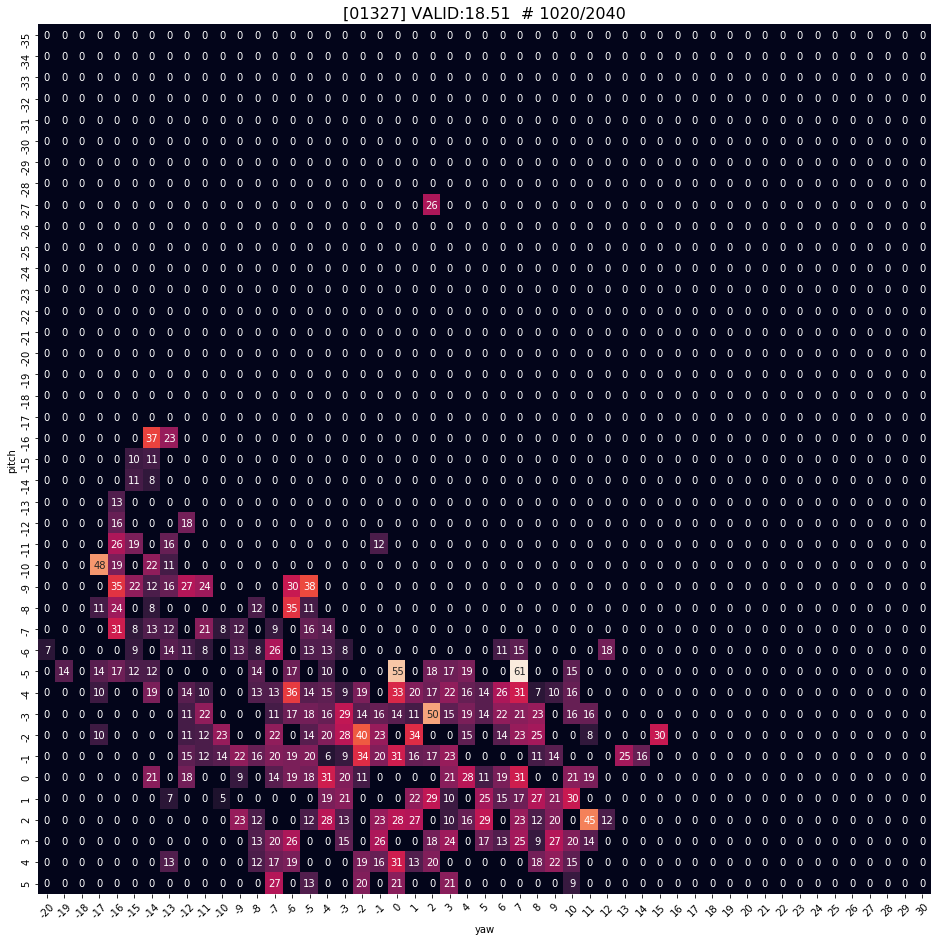

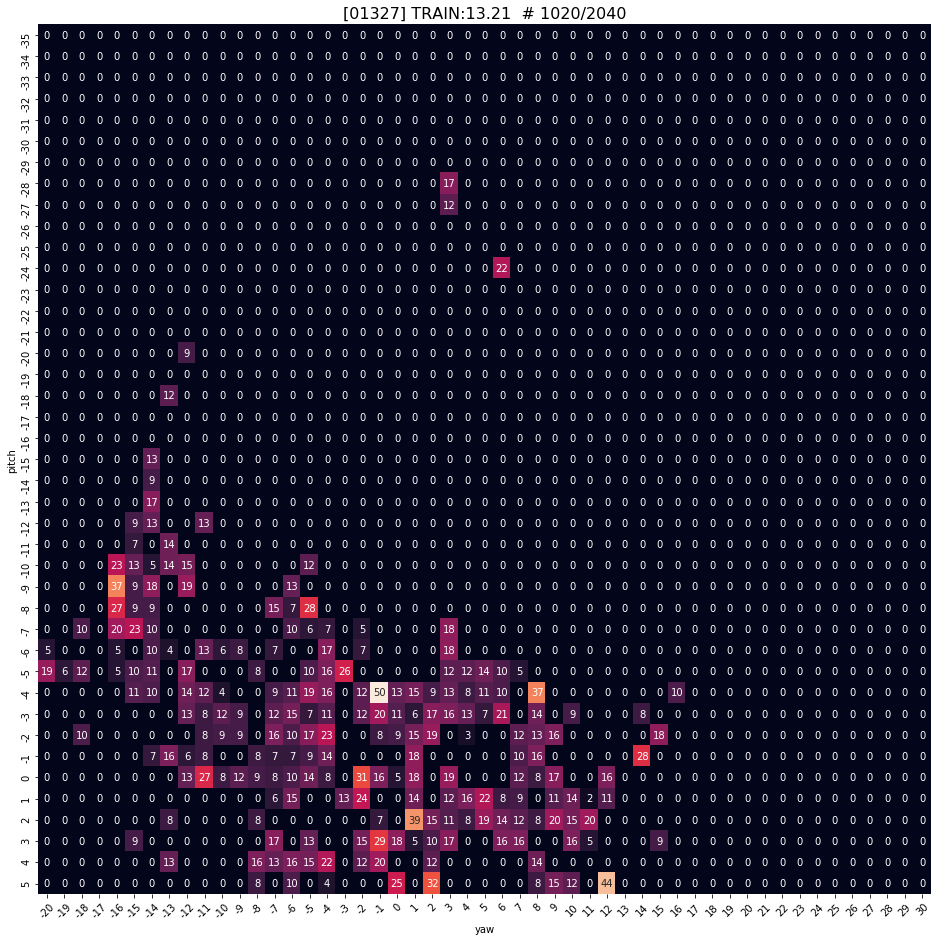

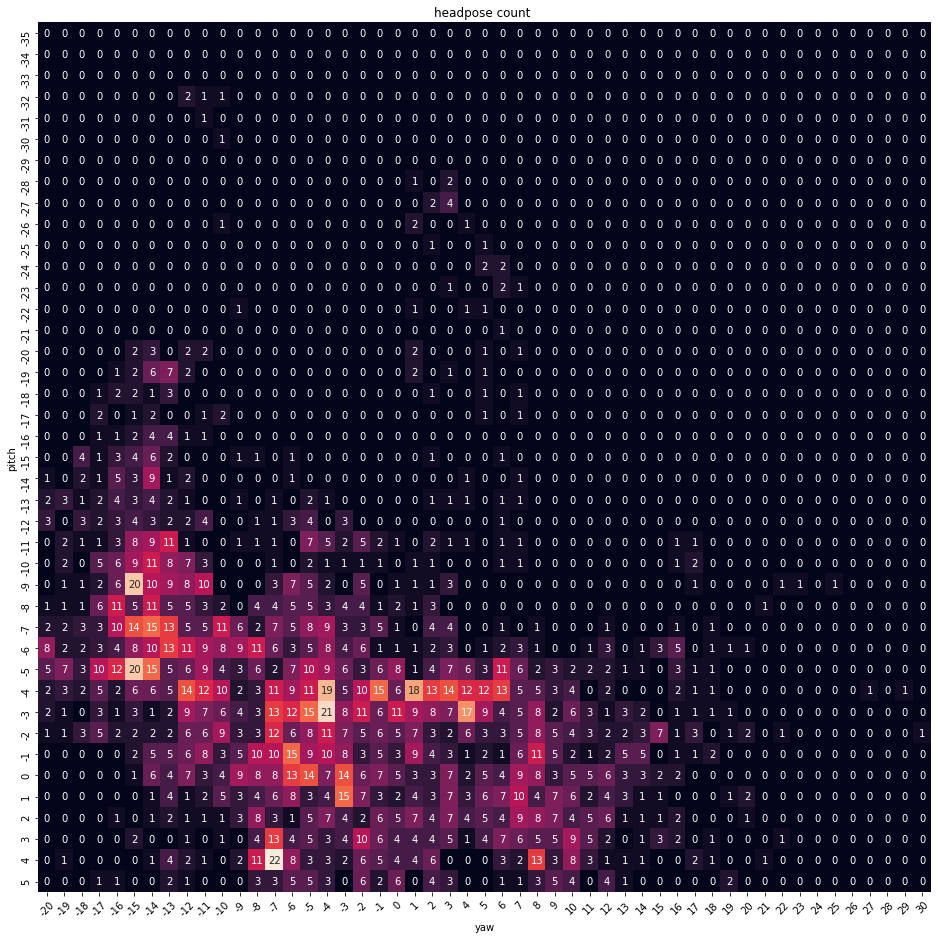

In [362]:
er = show_error_report('01327', r_table, ['pitch','yaw'], x_rng=[-35,5], y_rng=[-20, 30])